In [391]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as st
import itertools
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import AR
from statsmodels.tsa.statespace.sarimax import SARIMAX
import scipy.stats as stats
import pylab 
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from pandas import to_datetime

def addZero(symbol):#该函数负责将股票代码前面的0补全
    if(len(symbol)==1):
        return "00000"+symbol
    if(len(symbol)==2):
        return "0000"+symbol
    if(len(symbol)==3):
        return "000"+symbol
    if(len(symbol)==4):
        return "00"+symbol
    if(len(symbol)==5):
        return "0"+symbol
    if(len(symbol)==6):
        return symbol
    
def plotsymbol(symbol,x,y):#画出代码为symbol的股票的图，x可以为日期，y可以为营收，利润等
    plt.plot(Income.loc[Income['TICKER_SYMBOL']==symbol][x],Income.loc[Income['TICKER_SYMBOL']==symbol][y])
    
def isContinuous(t):
    if (t.dtype!='datetime64[ns]'):
        raise "t must be 'datetime64[ns]'"
        return
    if t.size==pd.date_range(t.min(),t.max(),freq='Q').size:
        return True
    else:
        return False

Income=pd.read_excel("C:/FDDC_financial_data/FDDC_financial_data/Financial Data/Income Statement.xls",sheet_name="General Business")

In [392]:
#将股票代码变为字符串型
Income['TICKER_SYMBOL']=Income['TICKER_SYMBOL'].astype(str)
#股票代码加0
Income['TICKER_SYMBOL']=Income['TICKER_SYMBOL'].apply(addZero)
#将END_DATE转变为日期类型
Income['END_DATE']=pd.to_datetime(Income['END_DATE'],format='%Y-%m-%d')
Income=Income.loc[:,['END_DATE','TICKER_SYMBOL','REVENUE']]
Income=Income.sort_values(by=['END_DATE', 'TICKER_SYMBOL'])

In [393]:
Income[['TICKER_SYMBOL','END_DATE']].duplicated().sum()

97281

In [394]:
#观察重复值的样本，可以发现第二次重复的值有了新的值，可能是报告期补充了新的数据，
Income[(Income['TICKER_SYMBOL']=='000002')&(Income['END_DATE']=='2009-03-31')]

,END_DATE,TICKER_SYMBOL,REVENUE
940,2009-03-31,000002,8.164319e+09
1106,2009-03-31,000002,8.164319e+09


In [395]:
Income=Income.drop_duplicates(['END_DATE','TICKER_SYMBOL'],keep='last')
print ("处理后的数据有%d行，%d列"%(Income.shape[0],Income.shape[1]))

处理后的数据有110852行，3列


In [396]:
#观察同一只股票的同一期，是否还有重复值
Income[['TICKER_SYMBOL','END_DATE']].duplicated().sum()

0

In [397]:
#改变为日期类型index
Income.index=Income['END_DATE']
Income=Income.drop('END_DATE',axis=1)
Income.head()
train=Income
Income=[]
train=train['2008':]
train.head()

,TICKER_SYMBOL,REVENUE
END_DATE,,
2008-03-31,000002,6.400436e+09
2008-03-31,000004,8.841862e+06
2008-03-31,000005,1.847533e+07
2008-03-31,000006,7.035197e+08
2008-03-31,000007,4.336484e+07


In [398]:
symbol_discontinuous=[]
symbol_continuous=[]
for symbol in train['TICKER_SYMBOL'].unique():
    if (isContinuous(train[train['TICKER_SYMBOL']==symbol].index)==False):
        symbol_discontinuous.append(symbol)
        print ("%s的时间序列不连续"%symbol)
    else:
        symbol_continuous.append(symbol)

#for symbol in symbol_continuous:
#    train=train.append(Income[Income['TICKER_SYMBOL']==symbol])
    
#for symbol in symbol_discontinuous:
#    temp=Income[Income['TICKER_SYMBOL']==symbol]
#    new_index=pd.date_range(temp.index.min(),temp.index.max(),freq='Q')
#    new_index.strftime('%Y-%m-%d')
#    temp=temp.reindex(new_index)
#    temp.END_DATE=temp.index
#    temp.TICKER_SYMBOL=symbol
#    train=train.append(temp)


000627的时间序列不连续
000693的时间序列不连续
000722的时间序列不连续
300077的时间序列不连续
600094的时间序列不连续
601668的时间序列不连续
300444的时间序列不连续
600050的时间序列不连续
601018的时间序列不连续
002445的时间序列不连续
002446的时间序列不连续
002448的时间序列不连续
002450的时间序列不连续
002451的时间序列不连续
002452的时间序列不连续
002453的时间序列不连续
002455的时间序列不连续
002457的时间序列不连续
002458的时间序列不连续
002459的时间序列不连续
002460的时间序列不连续
002461的时间序列不连续
002462的时间序列不连续
002463的时间序列不连续
002464的时间序列不连续
002465的时间序列不连续
002466的时间序列不连续
002467的时间序列不连续
002468的时间序列不连续
002469的时间序列不连续
002470的时间序列不连续
002471的时间序列不连续
002472的时间序列不连续
002473的时间序列不连续
002474的时间序列不连续
002475的时间序列不连续
002476的时间序列不连续
002477的时间序列不连续
002478的时间序列不连续
002479的时间序列不连续
002480的时间序列不连续
002481的时间序列不连续
002482的时间序列不连续
002483的时间序列不连续
002484的时间序列不连续
002485的时间序列不连续
002486的时间序列不连续
002487的时间序列不连续
002488的时间序列不连续
002490的时间序列不连续
002491的时间序列不连续
002492的时间序列不连续
002493的时间序列不连续
002494的时间序列不连续
002495的时间序列不连续
002496的时间序列不连续
002497的时间序列不连续
002498的时间序列不连续
002499的时间序列不连续
002501的时间序列不连续
002502的时间序列不连续
002503的时间序列不连续
002505的时间序列不连续
002506的时间序列不连续
002507的时间序列不连续
002508的时间序列不连续
002509的时间序

603128的时间序列不连续
603167的时间序列不连续
603197的时间序列不连续
603333的时间序列不连续
603359的时间序列不连续
603599的时间序列不连续
603861的时间序列不连续
603993的时间序列不连续
000333的时间序列不连续
002678的时间序列不连续
002679的时间序列不连续
002680的时间序列不连续
002681的时间序列不连续
002683的时间序列不连续
002684的时间序列不连续
002686的时间序列不连续
002687的时间序列不连续
002689的时间序列不连续
002692的时间序列不连续
002693的时间序列不连续
002694的时间序列不连续
002695的时间序列不连续
002697的时间序列不连续
002698的时间序列不连续
002700的时间序列不连续
002703的时间序列不连续
002710的时间序列不连续
002720的时间序列不连续
002743的时间序列不连续
002746的时间序列不连续
002748的时间序列不连续
002752的时间序列不连续
002756的时间序列不连续
002773的时间序列不连续
002782的时间序列不连续
002792的时间序列不连续
002815的时间序列不连续
002838的时间序列不连续
002843的时间序列不连续
002851的时间序列不连续
002905的时间序列不连续
300322的时间序列不连续
300323的时间序列不连续
300328的时间序列不连续
300332的时间序列不连续
300333的时间序列不连续
300334的时间序列不连续
300335的时间序列不连续
300336的时间序列不连续
300338的时间序列不连续
300341的时间序列不连续
300342的时间序列不连续
300347的时间序列不连续
300348的时间序列不连续
300349的时间序列不连续
300351的时间序列不连续
300352的时间序列不连续
300354的时间序列不连续
300355的时间序列不连续
300356的时间序列不连续
300361的时间序列不连续
300505的时间序列不连续
300507的时间序列不连续
300546的时间序列不连续
300567的时间序列不连续
600903的时间序列不连续
600959的时间序

300597的时间序列不连续
300598的时间序列不连续
300599的时间序列不连续
300600的时间序列不连续
300601的时间序列不连续
300602的时间序列不连续
300603的时间序列不连续
300605的时间序列不连续
300606的时间序列不连续
300607的时间序列不连续
300608的时间序列不连续
300609的时间序列不连续
300610的时间序列不连续
300611的时间序列不连续
300612的时间序列不连续
300615的时间序列不连续
300623的时间序列不连续
300631的时间序列不连续
300633的时间序列不连续
600936的时间序列不连续
600996的时间序列不连续
601020的时间序列不连续
601206的时间序列不连续
601212的时间序列不连续
601500的时间序列不连续
601595的时间序列不连续
601811的时间序列不连续
601858的时间序列不连续
601882的时间序列不连续
601966的时间序列不连续
603016的时间序列不连续
603027的时间序列不连续
603028的时间序列不连续
603029的时间序列不连续
603031的时间序列不连续
603032的时间序列不连续
603033的时间序列不连续
603035的时间序列不连续
603036的时间序列不连续
603037的时间序列不连续
603038的时间序列不连续
603039的时间序列不连续
603040的时间序列不连续
603058的时间序列不连续
603060的时间序列不连续
603067的时间序列不连续
603069的时间序列不连续
603089的时间序列不连续
603090的时间序列不连续
603098的时间序列不连续
603101的时间序列不连续
603131的时间序列不连续
603159的时间序列不连续
603160的时间序列不连续
603165的时间序列不连续
603177的时间序列不连续
603178的时间序列不连续
603186的时间序列不连续
603189的时间序列不连续
603203的时间序列不连续
603208的时间序列不连续
603218的时间序列不连续
603228的时间序列不连续
603238的时间序列不连续
603239的时间序列不连续
603258的时间序列不连续
603260的时间序

In [399]:
Revenue_na=[]
##检测营收是否有营收为空值的
for symbol in train['TICKER_SYMBOL'].unique():
    if train.loc[train['TICKER_SYMBOL']==symbol]['REVENUE'].isnull().sum()>0:
        Revenue_na.append(symbol)
print (Revenue_na)

['600145', '600149', '600421', '600738', '900957']


In [400]:
#将营收为空的值填充，采用双向填充
j=1
for symbol in Revenue_na:
    temp=train[train['TICKER_SYMBOL']==symbol]['REVENUE'].copy()
    #temp=temp.interpolate()
    #plt.subplot(5,1,j)
    #plt.plot(train.loc[train['TICKER_SYMBOL']==symbol]['REVENUE'])
    #j=j+1
    #plt.show()
    #for idx in temp.index:
    #train.loc[train.TICKER_SYMBOL==symbol,'REVENUE']=temp

In [401]:
train[train['TICKER_SYMBOL']=='603813']

,TICKER_SYMBOL,REVENUE
END_DATE,,
2014-12-31,603813,2.927711e+08
2015-12-31,603813,2.930216e+08
2016-09-30,603813,2.401592e+08
2016-12-31,603813,3.375656e+08
2017-03-31,603813,8.943773e+07
2017-06-30,603813,1.832392e+08
2017-09-30,603813,2.832332e+08
2017-12-31,603813,3.925134e+08
2018-03-31,603813,1.174657e+08


In [402]:
train.isnull().sum()

TICKER_SYMBOL    0
REVENUE          9
dtype: int64

In [403]:
train['TICKER_SYMBOL'].unique().shape

(3495,)

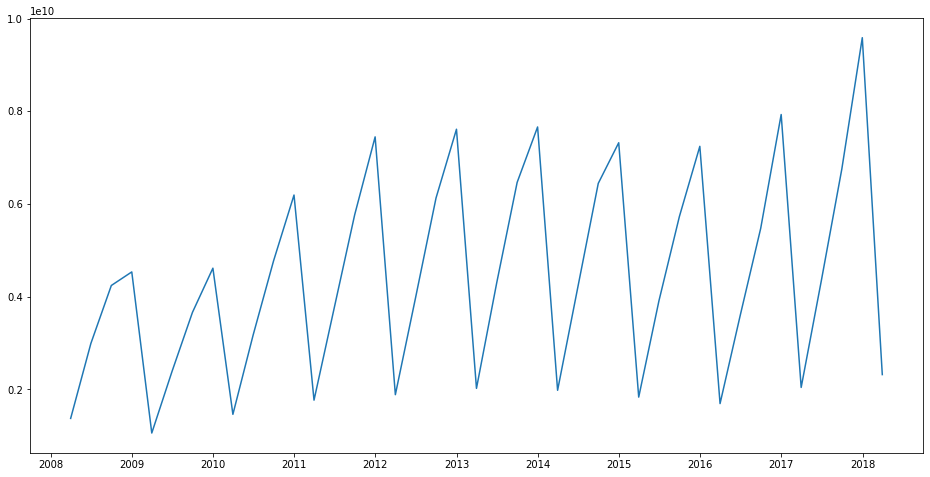

In [404]:
#全市场营收平均值的时间序列图
fig = plt.figure(figsize=(16,8))
#Income.loc['2008':]['REVENUE'].groupby(Income.index).mean()
plt.plot(train['REVENUE'].groupby(train.index).mean())

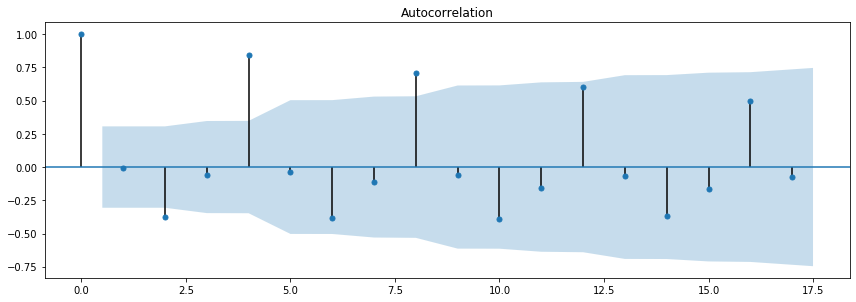

In [405]:
#全市场营收平均值的acf值
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(train['REVENUE'].groupby(train.index).mean(),ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout()

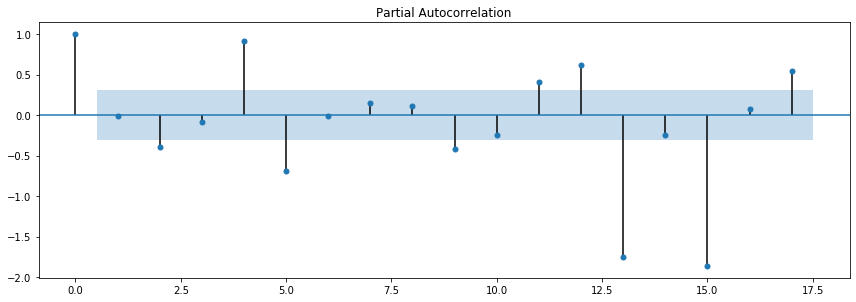

In [406]:
#全市场营收平均值的pacf值
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_pacf(train['REVENUE'].groupby(train.index).mean(),ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout()

In [407]:
#先预测包含最近两个完整年数据的公司
predict_each_stock=pd.DataFrame(columns=['TICKER_SYMBOL','REVENUE'])
for symbol in symbol_continuous:
    temp=train.loc[train['TICKER_SYMBOL']==symbol]['REVENUE']
    #temp=temp['2016':]#选取16年以来的
    #if(len(temp)==0):
        #continue
    #选取包含2018年一季度的
    if ((temp.index[-1]==pd.to_datetime('2018-03-31',format='%Y-%m-%d'))):
        #AR模型
        try:
            model = AR(temp)
            results_AR = model.fit(maxlag=8)
            predict_value = results_AR.predict(len(temp),len(temp))
            predict_each_stock=predict_each_stock.append({'REVENUE':predict_value.values[0],'TICKER_SYMBOL':symbol},ignore_index=True)
        except:
            continue
        #try:
        #ARMA模型
            #res=sm.tsa.arma_order_select_ic(temp, ic=['aic'])
            #arma_mod = ARMA(temp,order=res.aic_min_order)
            #print(symbol)
            #print(temp)
            #arma_mod = ARMA(temp,order=(6,8))
            #arma_res = arma_mod.fit()
            #print(arma_mod.params)
            #predict_value=arma_res.predict('2018-06',dynamic=True)
            #predict_each_stock=predict_each_stock.append({'REVENUE':predict_value.values[0],'TICKER_SYMBOL':symbol},ignore_index=True)
            #print(predict_value)
        #except:
            #continue

In [408]:
predict_each_stock

,TICKER_SYMBOL,REVENUE
0,000002,8.228179e+10
1,000004,2.610180e+08
2,000005,3.295325e+08
3,000006,9.408973e+08
4,000007,2.733879e+07
5,000008,5.435501e+08
6,000009,3.782475e+09
7,000010,1.107774e+08
8,000011,5.394823e+08
9,000012,4.895740e+09


In [409]:
predict_each_stock.sort_values(by='REVENUE',ascending=False)

,TICKER_SYMBOL,REVENUE
744,600028,1.269354e+12
1525,601857,1.022938e+12
801,600104,4.154760e+11
1516,601390,3.092160e+11
1514,601186,3.007569e+11
1297,600704,1.825192e+11
1212,600606,1.718055e+11
759,600057,1.537483e+11
738,600019,1.422795e+11
1511,601088,1.262372e+11


In [410]:
for symbol in predict_each_stock['TICKER_SYMBOL']:
    idx=predict_each_stock.loc[predict_each_stock['TICKER_SYMBOL']==symbol].index
    this_year=predict_each_stock.loc[idx,'REVENUE']
    last_year=train.loc[train['TICKER_SYMBOL']==symbol]['2017-06']['REVENUE']
    growth_rate=(this_year.values[0]-last_year.values[0])/last_year.values[0]
    predict_each_stock.loc[idx,'GROWTH_RATE']=growth_rate

In [411]:
predict_each_stock.sort_values(by='GROWTH_RATE')

,TICKER_SYMBOL,REVENUE,GROWTH_RATE
607,002164,-4.049580e+10,-123.485876
100,000505,-3.111610e+10,-80.007606
362,000892,-9.935353e+09,-40.103444
387,000923,-2.773871e+09,-21.341562
1831,601188,-2.135460e+09,-10.002816
429,000980,-4.061327e+10,-8.018511
103,000509,-4.872518e+09,-7.672342
1720,002408,-2.766772e+10,-6.887742
1350,600760,-2.655156e+09,-5.849018
186,000615,-2.793914e+09,-5.160692


In [412]:
predict_each_stock[['GROWTH_RATE']].describe()

,GROWTH_RATE
count,1837.000000
mean,0.074490
std,3.939805
min,-123.485876
25%,-0.041443
50%,0.064361
75%,0.211273
max,28.768460


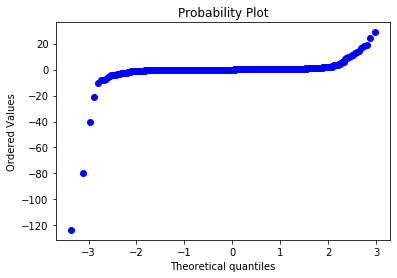

In [413]:
stats.probplot(predict_each_stock['GROWTH_RATE'], dist="norm", plot=pylab)
pylab.show()

In [414]:
#看看上下5%分位数占多少，去掉上下5%分位数
#len(predict_each_stock.loc[(predict_each_stock['GROWTH_RATE']<predict_each_stock['GROWTH_RATE'].quantile(0.95))&(predict_each_stock['GROWTH_RATE']>predict_each_stock['GROWTH_RATE'].quantile(0.05))])
predict_each_stock=predict_each_stock.loc[(predict_each_stock['GROWTH_RATE']<predict_each_stock['GROWTH_RATE'].quantile(0.95))&(predict_each_stock['GROWTH_RATE']>predict_each_stock['GROWTH_RATE'].quantile(0.05))]

In [415]:
predict_each_stock.sort_values(by='GROWTH_RATE')

,TICKER_SYMBOL,REVENUE,GROWTH_RATE
1767,300038,5.626926e+08,-0.410026
819,600123,2.364963e+09,-0.405020
267,000735,5.338499e+08,-0.396364
1279,600685,6.416397e+09,-0.384077
591,002148,1.798330e+08,-0.382626
865,600179,1.602740e+09,-0.375568
1268,600674,2.208253e+08,-0.372601
222,000671,4.834987e+09,-0.357460
151,000567,5.427372e+07,-0.352582
1263,600666,2.958915e+08,-0.349431


In [416]:
predict_each_stock[['GROWTH_RATE']].describe()

,GROWTH_RATE
count,1653.000000
mean,0.102266
std,0.226307
min,-0.410026
25%,-0.027061
50%,0.064361
75%,0.186259
max,0.994725


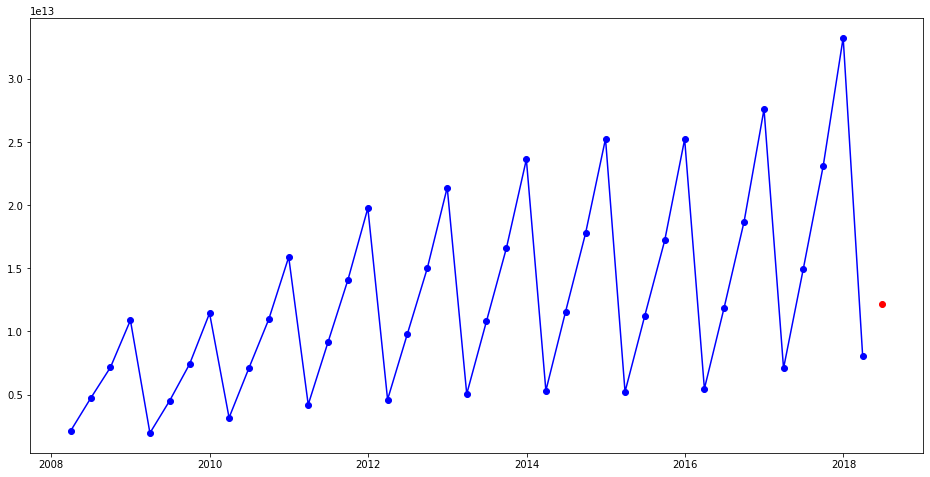

In [417]:
#全市场营收平均值的时间序列图以及二季度营收的预测值
fig = plt.figure(figsize=(16,8))
#Income.loc['2008':]['REVENUE'].groupby(Income.index).mean()
plt.plot(train['REVENUE'].groupby(train.index).sum(),'bo-')
plt.plot(pd.to_datetime('2018-06-30',format='%Y-%m-%d'),predict_each_stock['REVENUE'].sum(),'ro')

In [418]:
#predict_each_stock=predict_each_stock[predict_each_stock['REVENUE']>0]

In [419]:
#还没有预测营收的股票代码
not_predicted_symbol=np.setdiff1d(train['TICKER_SYMBOL'].unique(),predict_each_stock['TICKER_SYMBOL'].unique())
len(not_predicted_symbol)

1842

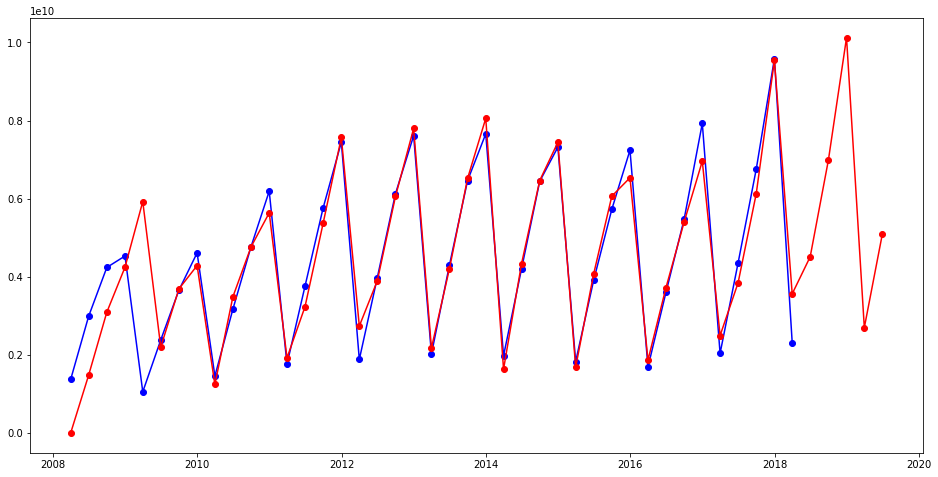

In [420]:
data=train.groupby(train.index).mean()
data=data['2008':]
p=q=[0,1,2]
d=[0,1]
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in pdq]
aic_min=10e5
result_order=result_seasonal_order=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
 
            results = mod.fit()
            if results.aic<aic_min:
                aic_min=results.aic
                result_order=param
                result_seasonal_order=param_seasonal
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

#全市场
mod=SARIMAX(data,order=result_order,seasonal_order=result_seasonal_order)
results=mod.fit()
predict=results.predict(0,len(data)+4)
fig = plt.figure(figsize=(16,8))
plt.plot(data,'bo-')
plt.plot(predict,'ro-')

In [421]:
#ratio=(data['2018-06']-data['2017-06']['REVENUE'])/data['2017-06']['REVENUE']
#ratio.values[0]
print(predict)
#同比增长
print((predict.shift(-4)-predict)/predict)

2008-03-31    0.000000e+00
2008-06-30    1.481289e+09
2008-09-30    3.093204e+09
2008-12-31    4.244880e+09
2009-03-31    5.925219e+09
2009-06-30    2.200057e+09
2009-09-30    3.690524e+09
2009-12-31    4.287201e+09
2010-03-31    1.243045e+09
2010-06-30    3.486150e+09
2010-09-30    4.765782e+09
2010-12-31    5.637355e+09
2011-03-31    1.924632e+09
2011-06-30    3.231470e+09
2011-09-30    5.373466e+09
2011-12-31    7.566398e+09
2012-03-31    2.739226e+09
2012-06-30    3.895625e+09
2012-09-30    6.056314e+09
2012-12-31    7.797133e+09
2013-03-31    2.174739e+09
2013-06-30    4.202618e+09
2013-09-30    6.519151e+09
2013-12-31    8.056288e+09
2014-03-31    1.632085e+09
2014-06-30    4.332623e+09
2014-09-30    6.462860e+09
2014-12-31    7.443161e+09
2015-03-31    1.684537e+09
2015-06-30    4.070953e+09
2015-09-30    6.063642e+09
2015-12-31    6.535366e+09
2016-03-31    1.865848e+09
2016-06-30    3.719079e+09
2016-09-30    5.401223e+09
2016-12-31    6.960049e+09
2017-03-31    2.495662e+09
2

In [422]:
#对于还未预测的股票代码，看看哪些是有以往多个完整的6月份数据的，因为从自相关函数看，18年2季度与以往2季度相关性最大
#方法一，用最近几年二季度营收平滑
#for symbol in not_predicted_symbol:
#    temp=train.loc[(train['TICKER_SYMBOL']==symbol)&(train.index.month==6)]['REVENUE']
#    try:
#        growth_rate_list=(temp.shift(-1)-temp)/temp
#        growth_rate_list=growth_rate_list.loc[(growth_rate_list<growth_rate_list.quantile(0.95))&(growth_rate_list>growth_rate_list.quantile(0.05))]
#        growth_rate=np.mean(growth_rate_list)
#        last_year=train.loc[train['TICKER_SYMBOL']==symbol]['2017-06']['REVENUE']
#        if((len(growth_rate_list)>0)&(len(last_year)>0)):
#            this_year=last_year.values[0]*(1+growth_rate)
#            predict_each_stock=predict_each_stock.append({'REVENUE':this_year,'TICKER_SYMBOL':symbol,'GROWTH_RATE':growth_rate},ignore_index=True)
#    except:
#        continue

In [423]:
#对于还未预测的股票代码，看看哪些是有以往多个完整的6月份数据的，因为从自相关函数看，18年2季度与以往2季度相关性最大
#方法一，用最近几年ARIMA平滑
for symbol in not_predicted_symbol:
    temp=train.loc[train['TICKER_SYMBOL']==symbol]['REVENUE']
    try:
        mod=SARIMAX(temp,order=result_order,seasonal_order=result_seasonal_order)
        results=mod.fit()
        predict=results.predict(len(data),len(data))
        last_year=train.loc[train['TICKER_SYMBOL']==symbol]['2017-06']['REVENUE'].values[0]
        this_year=predict.values[0]
        growth_rate=(this_year-last_year)/last_year
        predict_each_stock=predict_each_stock.append({'REVENUE':this_year,'TICKER_SYMBOL':symbol,'GROWTH_RATE':growth_rate},ignore_index=True)
    except:
        continue

In [424]:
#growth_rate_list=growth_rate_list.loc[(growth_rate_list<growth_rate_list.quantile(0.95))&(growth_rate_list>growth_rate_list.quantile(0.05))]   
predict_each_stock

,TICKER_SYMBOL,REVENUE,GROWTH_RATE
0,000002,8.228179e+10,0.178645
1,000005,3.295325e+08,0.618539
2,000007,2.733879e+07,0.258365
3,000008,5.435501e+08,-0.043792
4,000009,3.782475e+09,0.286917
5,000012,4.895740e+09,-0.009829
6,000014,2.964305e+08,-0.019417
7,000016,1.217686e+10,0.067587
8,000017,4.717130e+07,-0.035937
9,000018,3.078147e+09,0.017541


In [425]:
#方法二，用最近两年的AR。因为营收有异常的，往往是最近两年数据导致的
#for symbol in set(not_predicted_symbol).intersection(set(symbol_continuous)):
#    temp=train.loc[train['TICKER_SYMBOL']==symbol]['REVENUE'][-8:]
#    try:
#        arma_mod = AR(temp)
#        arma_res = arma_mod.fit()
#        predict_value=arma_res.predict(len(temp),len(temp))
#        this_year=predict_value
#        last_year=train.loc[train['TICKER_SYMBOL']==symbol]['2017-06']['REVENUE']
#        growth_rate=(this_year.values[0]-last_year.values[0])/last_year.values[0]
#        predict_each_stock=predict_each_stock.append({'REVENUE':predict_value.values[0],'TICKER_SYMBOL':symbol,'GROWTH_RATE':growth_rate},ignore_index=True)
#    except:
#        continue

In [426]:
#测试方法一

#temp=train.loc[(train['TICKER_SYMBOL']=='000004')&(train.index.month==6)]['REVENUE'] 
#growth_rate_list=(temp.shift(-1)-temp)/temp
#growth_rate_list=growth_rate_list.loc[(growth_rate_list<growth_rate_list.quantile(0.95))&(growth_rate_list>growth_rate_list.quantile(0.05))]
#growth_rate=np.mean(growth_rate_list)
#last_year=train.loc[train['TICKER_SYMBOL']==symbol]['2017-06']['REVENUE']
#last_year.values[0]
#this_year=last_year.values[0]*(1+growth_rate)
#np.mean((temp.shift(-1)-temp)/temp)


In [427]:
predict_each_stock.sort_values(by='GROWTH_RATE')

,TICKER_SYMBOL,REVENUE,GROWTH_RATE
1727,002164,-8.545271e+09,-26.846504
1873,002575,-3.143097e+08,-6.827476
1945,002647,-9.539668e+08,-5.288354
2091,300184,-1.402004e+10,-4.914418
1696,000803,-2.399440e+07,-2.631835
1670,000509,-7.654812e+08,-2.048237
2337,600822,-2.655440e+09,-1.864554
1968,002670,-5.083682e+08,-1.803716
2330,600751,-1.134672e+11,-1.777031
1692,000727,-1.758975e+09,-1.594985


In [428]:
predict_each_stock[['GROWTH_RATE']].describe()

,GROWTH_RATE
count,2423.000000
mean,1.892749
std,69.656872
min,-26.846504
25%,-0.017053
50%,0.113200
75%,0.456363
max,3424.755800


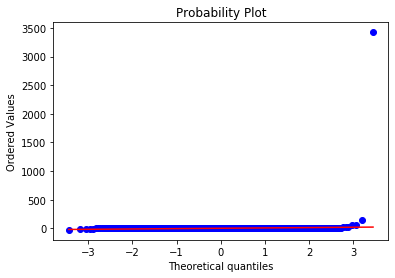

In [429]:
stats.probplot(predict_each_stock['GROWTH_RATE'], dist="norm", plot=pylab)
pylab.show()

In [430]:
predict_each_stock=predict_each_stock.loc[(predict_each_stock['GROWTH_RATE']<predict_each_stock['GROWTH_RATE'].quantile(0.95))&(predict_each_stock['GROWTH_RATE']>predict_each_stock['GROWTH_RATE'].quantile(0.05))]

In [431]:
predict_each_stock[['GROWTH_RATE']].describe()

,GROWTH_RATE
count,2179.000000
mean,0.273269
std,0.442851
min,-0.286004
25%,-0.000643
50%,0.113200
75%,0.381218
max,1.831474


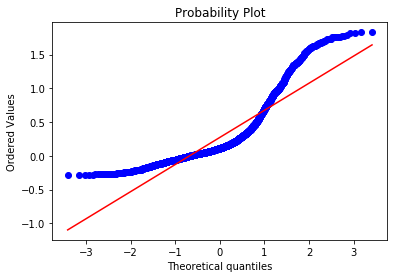

In [432]:
stats.probplot(predict_each_stock['GROWTH_RATE'], dist="norm", plot=pylab)
pylab.show()

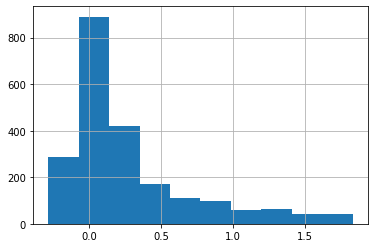

In [433]:
predict_each_stock['GROWTH_RATE'].hist()

In [434]:
#再刷一遍还没有预测营收的股票代码
not_predicted_symbol=np.setdiff1d(train['TICKER_SYMBOL'].unique(),predict_each_stock['TICKER_SYMBOL'].unique())
len(not_predicted_symbol)

1316

In [435]:
len(np.setdiff1d(not_predicted_symbol,symbol_continuous))

1190

In [436]:
for symbol in np.setdiff1d(not_predicted_symbol,symbol_continuous):
    try:
        temp=train.loc[train['TICKER_SYMBOL']==symbol]['REVENUE'][-8:]
        model = AR(temp)
        results_AR = model.fit()
        predict_value = results_AR.predict(len(temp),len(temp))
        
        last_year=train.loc[train['TICKER_SYMBOL']==symbol]['2017-06']['REVENUE'].values[0]
        this_year=predict_value.values[0]
        growth_rate=(this_year-last_year)/last_year
        predict_each_stock=predict_each_stock.append({'REVENUE':this_year,'TICKER_SYMBOL':symbol,'GROWTH_RATE':growth_rate},ignore_index=True)
    except:
        continue

In [437]:
predict_each_stock.sort_values(by='GROWTH_RATE')

,TICKER_SYMBOL,REVENUE,GROWTH_RATE
2467,300268,-3.875494e+09,-15885.129374
2477,300308,-4.582885e+09,-65.924718
2204,002629,-1.375370e+10,-10.530329
2435,300184,-9.137520e+09,-3.551211
2478,300309,-7.984579e+08,-3.300548
2956,603099,-1.342009e+08,-2.759861
3283,603993,-1.278557e+10,-2.097008
2203,002621,-6.556547e+07,-2.095448
3227,603871,-1.413527e+09,-1.986496
2432,300178,-1.376584e+09,-1.981091


In [438]:
#本次去除营收为负值的
predict_each_stock=predict_each_stock.loc[predict_each_stock['REVENUE']>0]

In [439]:
#predict_each_stock['REVENUE'].mean()-train.groupby(train.index).mean()['2017-06']['REVENUE']
#predict_each_stock['REVENUE'].mean()
#train.groupby(train.index).mean()['2017-06']['REVENUE']
ratio=(predict_each_stock['REVENUE'].mean()-train.groupby(train.index).mean()['2017-06']['REVENUE'])/train.groupby(train.index).mean()['2017-06']['REVENUE']
ratio.values[0]

0.20212310925076607

In [440]:
predict_each_stock.sort_values(by='GROWTH_RATE')

,TICKER_SYMBOL,REVENUE,GROWTH_RATE
2472,300288,1.222227e+07,-0.987560
2338,002828,1.770326e+07,-0.913540
2471,300282,1.452349e+08,-0.828389
3193,603789,7.518322e+07,-0.810099
2579,300447,6.383909e+07,-0.767291
2448,300216,1.061226e+08,-0.762653
2864,601212,6.507752e+09,-0.757887
2233,002711,6.693804e+08,-0.755658
2363,002857,1.769244e+07,-0.725090
2230,002707,1.428277e+09,-0.716950


In [441]:
#对营收为负值的，测试AR参数
#from statsmodels.tsa.arima_model import ARIMA
#print(temp.diff(1)[1:])

#temp=train.loc[train['TICKER_SYMBOL']=='300649']['REVENUE'][-8:]
#t=sm.tsa.stattools.adfuller(temp)
#print(t[1])
#arma_mod = AR(temp)
#arma_res = arma_mod.fit()
#print(arma_res.params)
#predict_value=arma_res.predict(len(temp),len(temp))
#print(predict_value)
#fig = plt.figure(figsize=(16,8))
#plt.plot(train.loc[train['TICKER_SYMBOL']=='300649']['REVENUE'],'bo-')
#plt.plot(pd.to_datetime('2018-06-30',format='%Y-%m-%d'),predict_value,'ro')

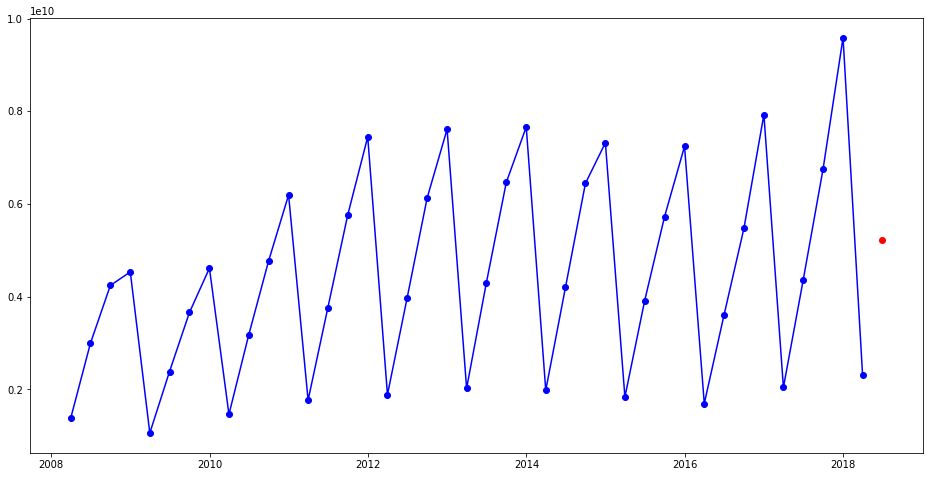

In [442]:
#全市场营收平均值的时间序列图以及二季度营收的预测值
fig = plt.figure(figsize=(16,8))
#Income.loc['2008':]['REVENUE'].groupby(Income.index).mean()
plt.plot(train['REVENUE'].groupby(train.index).mean(),'bo-')
plt.plot(pd.to_datetime('2018-06-30',format='%Y-%m-%d'),predict_each_stock['REVENUE'].mean(),'ro')

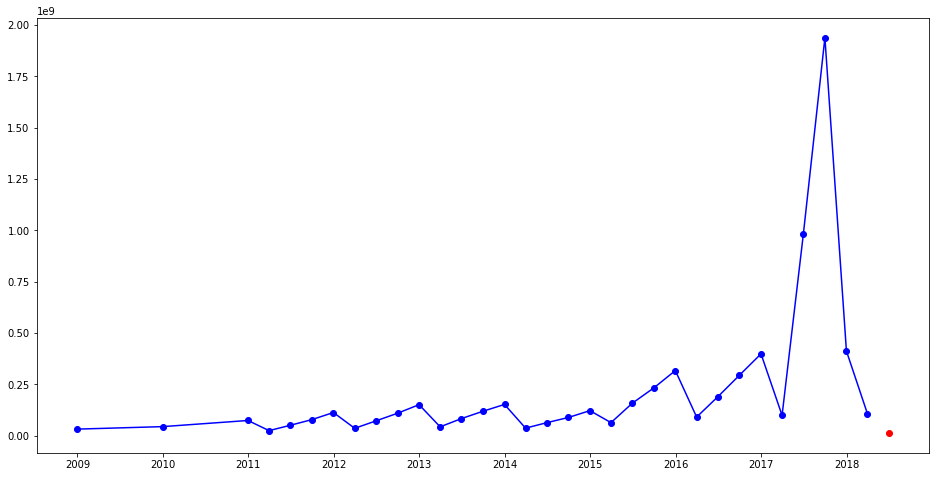

In [443]:
#测试用
fig = plt.figure(figsize=(16,8))
#Income.loc['2008':]['REVENUE'].groupby(Income.index).mean()
plt.plot(train.loc[train['TICKER_SYMBOL']=='300288']['REVENUE'],'bo-')
#train.loc[predict_each_stock['TICKER_SYMBOL']=='600462']['REVENUE]
plt.plot(pd.to_datetime('2018-06-30',format='%Y-%m-%d'),predict_each_stock.loc[predict_each_stock['TICKER_SYMBOL']=='300288']['REVENUE'],'ro')

In [444]:
#再刷一遍还没有预测营收的股票代码
not_predicted_symbol=np.setdiff1d(train['TICKER_SYMBOL'].unique(),predict_each_stock['TICKER_SYMBOL'].unique())
len(not_predicted_symbol)

228

In [445]:
for symbol in not_predicted_symbol:
    try:
        growth_rate=ratio.values[0]
        this_year=train.loc[train['TICKER_SYMBOL']==symbol]['2017-06']['REVENUE']*growth_rate
        predict_each_stock=predict_each_stock.append({'REVENUE':this_year.values[0],'TICKER_SYMBOL':symbol,'GROWTH_RATE':growth_rate},ignore_index=True)
    except:
        continue
        #print(train.loc[train['TICKER_SYMBOL']==symbol]['2017-06']['REVENUE'])

In [446]:
#再刷一遍还没有预测营收的股票代码
not_predicted_symbol=np.setdiff1d(train['TICKER_SYMBOL'].unique(),predict_each_stock['TICKER_SYMBOL'].unique())
len(not_predicted_symbol)

59

In [447]:
for symbol in not_predicted_symbol:
    print(train.loc[train['TICKER_SYMBOL']==symbol].index)

DatetimeIndex(['2008-03-31', '2008-06-30', '2008-09-30', '2008-12-31',
               '2009-03-31', '2009-06-30', '2009-09-30', '2009-12-31',
               '2010-03-31', '2010-06-30', '2010-09-30', '2010-12-31',
               '2011-03-31'],
              dtype='datetime64[ns]', name='END_DATE', freq=None)
DatetimeIndex(['2008-03-31', '2008-06-30', '2008-09-30', '2008-12-31',
               '2009-03-31', '2009-06-30', '2009-09-30', '2009-12-31'],
              dtype='datetime64[ns]', name='END_DATE', freq=None)
DatetimeIndex(['2014-12-31', '2015-12-31', '2016-12-31', '2017-03-31',
               '2017-09-30', '2017-12-31', '2018-03-31'],
              dtype='datetime64[ns]', name='END_DATE', freq=None)
DatetimeIndex(['2008-12-31', '2009-09-30', '2009-12-31', '2010-06-30',
               '2010-09-30'],
              dtype='datetime64[ns]', name='END_DATE', freq=None)
DatetimeIndex(['2011-06-30', '2011-09-30', '2012-06-30', '2012-09-30'], dtype='datetime64[ns]', name='END_DATE', freq=No

DatetimeIndex(['2015-12-31', '2016-12-31', '2017-12-31'], dtype='datetime64[ns]', name='END_DATE', freq=None)
DatetimeIndex(['2015-12-31', '2016-12-31', '2017-12-31'], dtype='datetime64[ns]', name='END_DATE', freq=None)
DatetimeIndex(['2015-12-31', '2016-12-31', '2017-12-31'], dtype='datetime64[ns]', name='END_DATE', freq=None)
DatetimeIndex(['2014-12-31', '2015-12-31', '2016-12-31', '2017-03-31',
               '2017-09-30', '2017-12-31', '2018-03-31'],
              dtype='datetime64[ns]', name='END_DATE', freq=None)
DatetimeIndex(['2014-12-31', '2015-12-31', '2016-09-30', '2016-12-31',
               '2017-03-31', '2017-09-30', '2017-12-31', '2018-03-31'],
              dtype='datetime64[ns]', name='END_DATE', freq=None)
DatetimeIndex(['2015-12-31', '2016-12-31', '2017-03-31', '2017-12-31',
               '2018-03-31'],
              dtype='datetime64[ns]', name='END_DATE', freq=None)
DatetimeIndex(['2015-12-31', '2016-12-31', '2017-03-31', '2017-12-31',
               '2018-03-31']

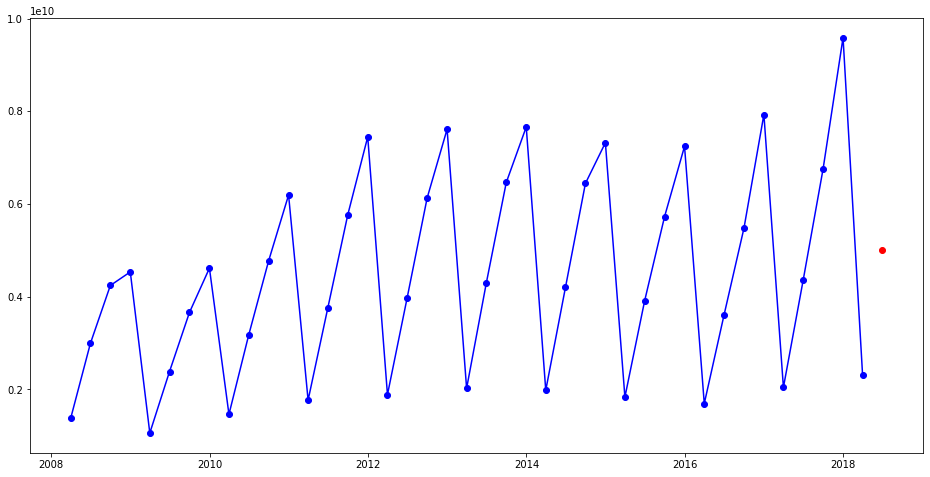

In [448]:
#全市场营收平均值的时间序列图以及二季度营收的预测值
fig = plt.figure(figsize=(16,8))
#Income.loc['2008':]['REVENUE'].groupby(Income.index).mean()
plt.plot(train['REVENUE'].groupby(train.index).mean(),'bo-')
plt.plot(pd.to_datetime('2018-06-30',format='%Y-%m-%d'),predict_each_stock['REVENUE'].mean(),'ro')